In [2]:
import numpy as np
import requests
import gzip
import matplotlib.pyplot as plt

In [3]:
def download_and_load_mnist():
    base_url = "http://yann.lecun.com/exdb/mnist/"
    file_names = ["train-images-idx3-ubyte.gz", "train-labels-idx1-ubyte.gz", 
                  "t10k-images-idx3-ubyte.gz", "t10k-labels-idx1-ubyte.gz"]

    mnist_data = []
    for file_name in file_names:
        response = requests.get(base_url + file_name, stream=True)

        with gzip.open(response.raw, 'rb') as f:
            if "images" in file_name:
                # Skip the magic number and dimensions info
                mnist_data.append(np.frombuffer(f.read(), dtype=np.uint8, offset=16).reshape(-1, 28, 28))
            else:
                # Skip the magic number
                mnist_data.append(np.frombuffer(f.read(), dtype=np.uint8, offset=8))

    return mnist_data

x_train, y_train, x_test, y_test = download_and_load_mnist()

In [4]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

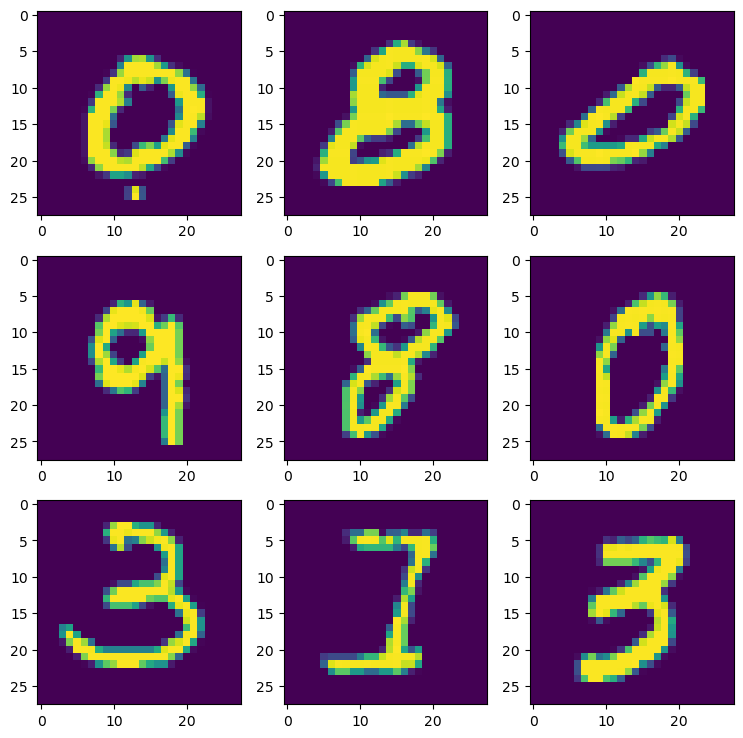

In [5]:
fig, axs = plt.subplots(3, 3, figsize=(9, 9))
axs = axs.ravel()

for i, j in enumerate(np.random.randint(0, 60000, (9,))):
    axs[i].imshow(x_train[j])
plt.show()

In [6]:

n_classes = len(set([y.item() for y in y_train]))

x_train_r = x_train.reshape(x_train.shape[0], -1)
x_test_r = x_test.reshape(x_test.shape[0], -1)

print(x_train_r.shape, x_test_r.shape, y_train.shape, y_test.shape)

n_samples = x_train_r.shape[0]
n_features = x_train_r.shape[1]

print(n_samples, n_features, n_classes)

(60000, 784) (10000, 784) (60000,) (10000,)
60000 784 10


In [7]:
# Initialise

# worth noting that keras and pytorch initialise normal distributions slightly differently (before gain and adjustments)
# keras uses truncated normal distribution while pytorch uses unmodified normal distribution
# below I am going with pytorch method and initialising a standard normal distribution

layer1_size = 512
layer2_size = 256

W1 = np.random.randn(n_features, layer1_size) * (2/(n_features+layer1_size))**0.5
b1 = np.zeros(layer1_size)
W2 = np.random.randn(layer1_size, layer2_size) * (2/(layer1_size+layer2_size))**0.5
b2 = np.zeros(layer2_size)
W3 = np.random.randn(layer2_size, n_classes) * (2/(layer2_size+n_classes))**0.5
b3 = np.zeros(n_classes)

parameters = [W1, b1, W2, b2, W3, b3]

print(sum(p.size for p in parameters))

535818


In [8]:
EPOCHS = 100
BATCH_SIZE = 128

losses = []
accuracies = []

for epoch in range(EPOCHS):
    print(f"Training Epoch {epoch+1}")
    epoch_loss = []
    epoch_acc = []
    log_probs_all = []
    
    batches = np.array_split(np.random.permutation(n_samples), n_samples/BATCH_SIZE) # this creates batches of both size 129 and 128

    for i, batch_idx in enumerate(batches):
        # print(f"Batch {i}")
        # batch
        x_batch, y_batch = x_train_r[batch_idx], y_train[batch_idx]
        n_batch = batch_idx.shape[0]
        
        # forward pass
        layer1_logits = x_batch @ W1 + b1
        layer1_outputs = np.tanh(layer1_logits)
        layer2_logits = layer1_outputs @ W2 + b2
        layer2_outputs = np.tanh(layer2_logits)
        layer3_logits = layer2_outputs @ W3 + b3
        
        max_logits = np.max(layer3_logits, axis=1)
        norm_logits = layer3_logits - max_logits[:,np.newaxis]  # normalise logits to prevent exponential exploding in the next step
        exp_logits = np.exp(norm_logits)
        sum_logits = np.sum(exp_logits, axis=1)
        probs = exp_logits / sum_logits[:, np.newaxis]

        logprobs = np.log(probs)
        loss = -np.mean(logprobs[np.arange(n_batch), y_batch])
        epoch_loss.append(loss)
        # print(loss)
        log_probs_all.append(logprobs[np.arange(n_batch), y_batch])
        
        pred = np.argmax(probs, axis=1)
        accuracy = (pred == y_batch).mean()
        epoch_acc.append(accuracy)
        # print(accuracy)

        # backward pass
        dlogprobs = np.zeros_like(logprobs)
        dlogprobs[np.arange(n_batch), y_batch] = 1
        dlogprobs *= -1/y_batch.shape[0]
        dprobs = 1/probs * dlogprobs
        dsum_logits = -sum_logits**-2 * np.sum(exp_logits * dprobs, axis=1)
        dexp_logits = dsum_logits[:, np.newaxis] * np.ones_like(exp_logits) + dprobs / sum_logits[:, np.newaxis]
        dnorm_logits = np.exp(norm_logits) * dexp_logits
        dmax_logits = -np.sum(dnorm_logits, axis=1)
        dlayer3_logits = np.ones_like(layer3_logits) * dnorm_logits
        temp = np.zeros_like(layer3_logits)
        temp[np.arange(n_batch), np.argmax(layer3_logits, axis=1)] = 1
        dlayer3_logits += temp * dmax_logits[:, np.newaxis]
        
        dW3 = layer2_outputs.T @ dlayer3_logits
        dlayer2_outputs = dlayer3_logits @ W3.T
        db3 = np.sum(dlayer3_logits, axis=0)
        dlayer2_logits = (np.ones_like(layer2_logits) - layer2_outputs**2) * dlayer2_outputs # correct

        dW2 = layer1_outputs.T @ dlayer2_logits
        dlayer1_outputs = dlayer2_logits @ W2.T
        db2 = np.sum(dlayer2_logits, axis=0)
        dlayer1_logits = (np.ones_like(layer1_logits) - layer1_outputs**2) * dlayer1_outputs # correct

        dW1 = x_batch.T @ dlayer1_logits
        dx_batch = dlayer1_logits @ W1.T
        db1 = np.sum(dlayer1_logits, axis=0)

        grads = [dW1, db1, dW2, db2, dW3, db3]
        for p, g in zip(parameters, grads):
            p += -0.01 * g
    
    #     break
    # break


    epoch_loss = sum(epoch_loss)/len(epoch_loss)
    losses.append(epoch_loss)
    print(f"     Loss is {epoch_loss}")

    epoch_acc = sum(epoch_acc) / len(epoch_acc)
    accuracies.append(epoch_acc.item())
    print(f"     Accuracy is {epoch_acc.item()*100:.2f}")
    # break

Training Epoch 1
     Loss is 0.5728140253232975
     Accuracy is 83.80
Training Epoch 2
     Loss is 0.314711192255358
     Accuracy is 91.18
Training Epoch 3
     Loss is 0.26447945815699
     Accuracy is 92.47
Training Epoch 4
     Loss is 0.23489646709179943
     Accuracy is 93.20
Training Epoch 5
     Loss is 0.2120638249258936
     Accuracy is 93.87
Training Epoch 6
     Loss is 0.19463141242628987
     Accuracy is 94.36
Training Epoch 7
     Loss is 0.18188525468995198
     Accuracy is 94.71
Training Epoch 8
     Loss is 0.17394775746097388
     Accuracy is 94.97
Training Epoch 9
     Loss is 0.16183695764539047
     Accuracy is 95.33
Training Epoch 10
     Loss is 0.156520366106773
     Accuracy is 95.46
Training Epoch 11
     Loss is 0.1486628613681351
     Accuracy is 95.70
Training Epoch 12
     Loss is 0.14273943936135258
     Accuracy is 95.86
Training Epoch 13
     Loss is 0.1386958841072659
     Accuracy is 95.95
Training Epoch 14
     Loss is 0.13216668953836877
     Ac

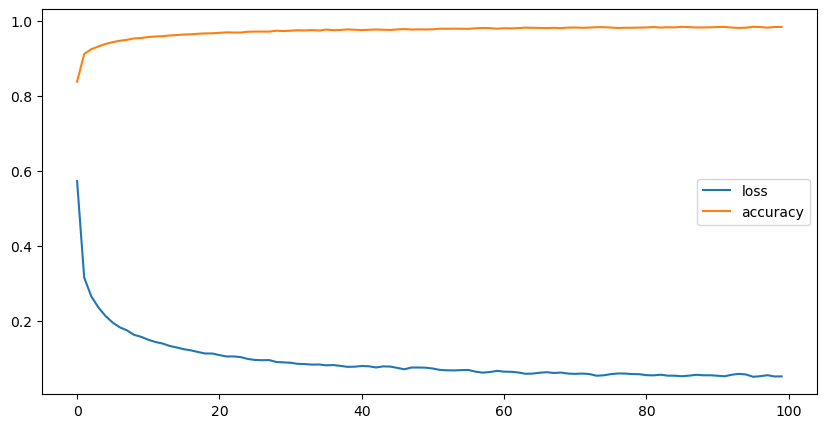

In [9]:
fig, ax = plt.subplots(figsize=(10,5))

ax.plot(losses, label='loss')
ax.plot(accuracies, label='accuracy')
ax.legend()

plt.show()

In [11]:
layer1_logits = x_test_r @ W1 + b1
layer1_outputs = np.tanh(layer1_logits)
layer2_logits = layer1_outputs @ W2 + b2
layer2_outputs = np.tanh(layer2_logits)
layer3_logits = layer2_outputs @ W3 + b3

max_logits = np.max(layer3_logits, axis=1)
norm_logits = layer3_logits - max_logits[:,np.newaxis]  # normalise logits to prevent exponential exploding in the next step
exp_logits = np.exp(norm_logits)
sum_logits = np.sum(exp_logits, axis=1)
probs = exp_logits / sum_logits[:, np.newaxis]

logprobs = np.log(probs)
loss = -np.mean(logprobs[np.arange(y_test.shape[0]), y_test])

pred = np.argmax(probs, axis=1)
accuracy = (pred == y_test).mean()

print(f"Test Loss is {loss}")
print(f"Test Accuracy is {accuracy*100:.2f}")

Test Loss is 0.09345989163694013
Test Accuracy is 97.06
